# END-TO-END IMPACT CALCULATION

Before computing the impact of a given exposure and hazard, it is important to correctly match the exposures' coordinates with the hazard centroids. Try to have similar resolutions in exposures and hazard. By the impact calculation the nearest neighbor for each exposure to the hazard's centroids is searched. 

Hint: set first the `Exposures` and use its coordinates information to set a matching `Hazard`.

## POINT EXPOSURES

If the exposures are points, compute your hazard at that points (if possible).

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


2021-02-08 17:33:15,988 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-02-08 17:33:15,989 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-02-08 17:33:15,989 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-02-08 17:33:15,990 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-02-08 17:33:15,993 - climada.entity.exposures.base - INFO - Setting if_ to default impact functions ids 1.
2021-02-08 17:33:15,995 - climada.entity.exposures.base - INFO - centr_ not set.
2021-02-08 17:33:15,995 - climada.entity.exposures.base - INFO - deductible not set.
2021-02-08 17:33:15,996 - climada.entity.exposures.base - INFO - cover not set.
2021-02-08 17:33:15,996 - climada.entity.exposures.base - INFO - category_id not set.
2021-02-08 17:33:15,996 - climada.entity.exposures.base - INFO - region_id not set.
2021-02-08 17:33:15,997 - climada.entity.exposures.base - INFO -

/Users/ckropf/Documents/Climada/climada_python/climada/util/plot.py:314: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


2021-02-08 17:33:18,346 - climada.hazard.tc_tracks - INFO - Progress: 100%
2021-02-08 17:33:18,373 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.


/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2021-02-08 17:33:18,691 - climada.util.coordinates - INFO - dist_to_coast: UTM 32645 (1/1)
2021-02-08 17:33:18,917 - climada.hazard.trop_cyclone - INFO - Mapping 1 tracks to 7 coastal centroids.
2021-02-08 17:33:18,925 - climada.hazard.trop_cyclone - INFO - Progress: 100%


/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/ckropf/Documents/Climada/climada_python/climada/util/plot.py:314: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough t

2021-02-08 17:33:19,253 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-08 17:33:19,254 - climada.entity.exposures.base - INFO - Matching 7 exposures with 7 centroids.
2021-02-08 17:33:19,256 - climada.engine.impact - INFO - Calculating damage for 7 assets (>0) and 1 events.
2021-02-08 17:33:19,257 - climada.engine.impact - INFO - Missing exposures impact functions for hazard if_TC. Using impact functions in if_.
Nearest neighbor hazard.centroids indexes for each exposure: [0 1 2 3 4 5 6]


/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/cartopy/mpl/feature_artist.py:225: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **dict(style))


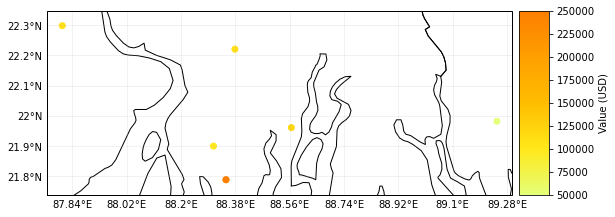

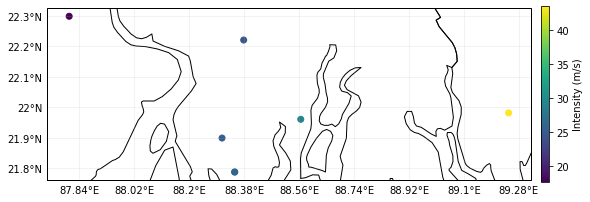

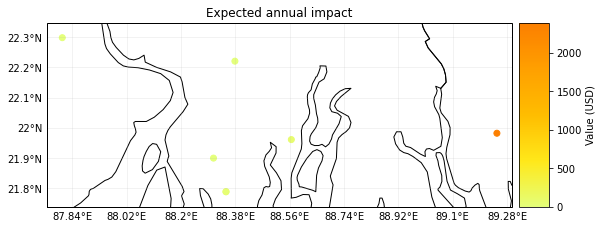

In [1]:
%matplotlib inline
# EXAMPLE: POINT EXPOSURES WITH POINT HAZARD
import numpy as np
from climada.entity import Exposures, ImpactFuncSet, IFTropCyclone
from climada.hazard import Centroids, TCTracks, TropCyclone
from climada.engine import Impact

# Set Exposures in points
exp_pnt = Exposures(crs={'init':'epsg:4326'})
exp_pnt.gdf['latitude'] = np.array([21.899326, 21.960728, 22.220574, 22.298390, 21.787977, 21.787977, 21.981732])
exp_pnt.gdf['longitude'] = np.array([88.307422, 88.565362, 88.378337, 87.806356, 88.348835, 88.348835, 89.246521])
exp_pnt.gdf['value'] = np.array([1.0e5, 1.2e5, 1.1e5, 1.1e5, 2.0e5, 2.5e5, 0.5e5])
exp_pnt.check()
exp_pnt.plot_scatter(buffer=0.05)

# Set Hazard in Exposures points
# set centroids from exposures coordinates
centr_pnt = Centroids()
centr_pnt.set_lat_lon(exp_pnt.gdf.latitude.values, exp_pnt.gdf.longitude.values, exp_pnt.crs)
# compute Hazard in that centroids
tr_pnt = TCTracks()
tr_pnt.read_ibtracs_netcdf(storm_id='2007314N10093')
tc_pnt = TropCyclone()
tc_pnt.set_from_tracks(tr_pnt, centroids=centr_pnt)
tc_pnt.check()
ax_pnt = tc_pnt.centroids.plot(c=np.array(tc_pnt.intensity[0,:].todense()).squeeze()) # plot intensity per point
ax_pnt.get_figure().colorbar(ax_pnt.collections[0], fraction=0.0175, pad=0.02).set_label('Intensity (m/s)') # add colorbar
#ax_pnt.get_figure().set_label('Intensity (m/s)')

# Set impact function
if_pnt = ImpactFuncSet()
if_tc = IFTropCyclone()
if_tc.set_emanuel_usa()
if_pnt.append(if_tc)
if_pnt.check()

# Compute Impact
imp_pnt = Impact()
imp_pnt.calc(exp_pnt, if_pnt, tc_pnt)
# nearest neighbor of exposures to centroids gives identity
print('Nearest neighbor hazard.centroids indexes for each exposure:', exp_pnt.gdf.centr_TC.values)
imp_pnt.plot_scatter_eai_exposure(ignore_zero=False, buffer=0.05)

## EXPOSURES FROM A RASTER

If the exposures represent values per pixel (belong to a raster), transform your hazard to a raster in the same reference system using the raster resampling options.

`BlackMarble` and `LitPop` belong to this category.

2021-02-08 17:33:21,767 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-02-08 17:33:21,768 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-02-08 17:33:21,768 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-02-08 17:33:21,769 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-02-08 17:33:21,770 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2021-02-08 17:33:22,921 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 300.0 arcsec.
2021-02-08 17:33:25,527 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GWP population data: 2015
2021-02-08 17:33:25,528 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-02-08 17:33:38,000 - climada.util.finance - INFO - GDP VEN 2014: 4.824e+11.
2021-02-08 17:33:

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/geopandas/geodataframe.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)
/Users/ckropf/Documents/Climada/climada_python/climada/util/plot.py:314: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/cartopy/mpl/feature_artist.py:225: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **dict(style))



 Raster properties exposures: {'width': 163, 'height': 138, 'crs': {'init': 'epsg:4326', 'no_defs': True}, 'transform': Affine(0.0833333333333286, 0.0, -73.41666666666669,
       0.0, -0.0833333333333286, 12.166666666666664)}
2021-02-08 17:33:40,980 - climada.util.coordinates - INFO - Reading /Users/ckropf/climada/demo/data/SC22000_VE__M1.grd.gz
Raster properties centroids: {'driver': 'GSBG', 'dtype': 'float32', 'nodata': 1.701410009187828e+38, 'width': 163, 'height': 138, 'count': 1, 'crs': {'init': 'epsg:4326', 'no_defs': True}, 'transform': Affine(0.0833333333333286, 0.0, -73.41666666666669,
       0.0, -0.0833333333333286, 12.166666666666664)}
2021-02-08 17:33:44,037 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.
2021-02-08 17:33:44,039 - climada.entity.exposures.base - INFO - Matching 10770 exposures with 22494 centroids.
2021-02

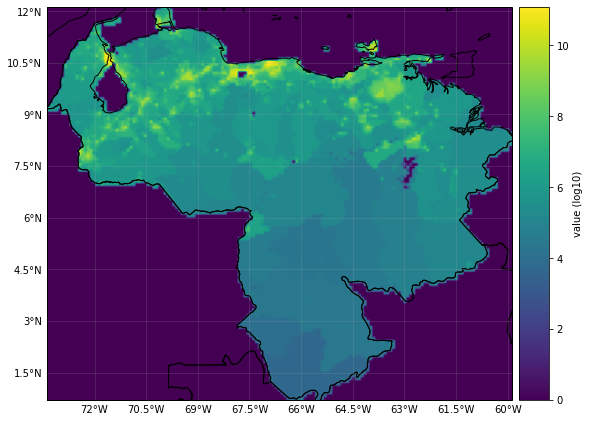

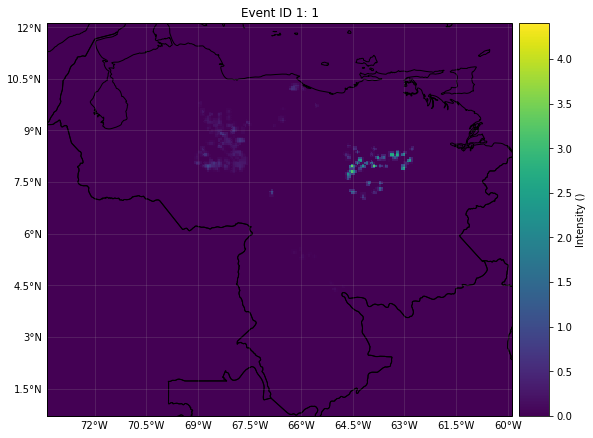

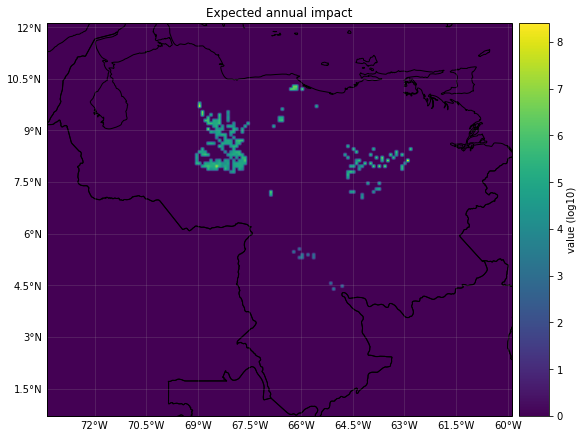

In [2]:
# EXAMPLE: RASTER EXPOSURES WITH RASTER HAZARD
from rasterio.warp import Resampling
from climada.entity import LitPop, ImpactFuncSet, ImpactFunc
from climada.hazard import Hazard
from climada.engine import Impact
from climada.util.constants import HAZ_DEMO_FL

# Exposures belonging to a raster contain the meta attribute
exp_ras = LitPop()
exp_ras.set_country(countries=['VEN'], res_km=10, fin_mode='income_group')
exp_ras.gdf.reset_index()
exp_ras.check()
exp_ras.plot_raster()
print('\n Raster properties exposures:', exp_ras.meta)

# Resample hazard raster to the exposures' ones
haz_ras = Hazard('FL')
# check how other resampling methods affect to final impact
haz_ras.set_raster([HAZ_DEMO_FL], dst_crs=exp_ras.meta['crs'], transform=exp_ras.meta['transform'], 
                   width=exp_ras.meta['width'], height=exp_ras.meta['height'], 
                   resampling=Resampling.nearest)
haz_ras.intensity[haz_ras.intensity==-9999] = 0 # correct no data values
haz_ras.check()
haz_ras.plot_intensity(1)
print('Raster properties centroids:', haz_ras.centroids.meta)

# Set dummy impact function
if_ras = ImpactFuncSet()
if_dum = ImpactFunc()
if_dum.id = 1
if_dum.name = 'dummy'
if_dum.intensity_unit = 'm'
if_dum.haz_type = 'FL'
if_dum.intensity = np.linspace(0, 10, 100)
if_dum.mdd = np.linspace(0, 10, 100)
if_dum.paa = np.ones(if_dum.intensity.size)
if_ras.append(if_dum)
if_ras.check()

# Compute impact
imp_ras = Impact()
imp_ras.calc(exp_ras, if_ras, haz_ras, save_mat=False)
# nearest neighbor of exposures to centroids is not identity because litpop does not contain data outside the country polygon
print('\n Nearest neighbor hazard.centroids indexes for each exposure:', exp_ras.gdf.centr_FL.values)
imp_ras.plot_raster_eai_exposure()

# VISUALIZATION

The expected annual impact per exposure can be visualized through different methods: `plot_hexbin_eai_exposure()`, `plot_scatter_eai_exposur()`, `plot_raster_eai_exposure()` and `plot_basemap_eai_exposure()` (similarly as with  `Exposures`).

2021-02-08 17:33:48,333 - climada.util.coordinates - INFO - Setting geometry points.
2021-02-08 17:33:48,422 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/ckropf/Documents/Climada/climada_python/climada/util/plot.py:314: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/contextily/tile.py:268: FutureWarning: The url format using 'tileX', 'tileY', 'tileZ' as placeholders is deprecated. Please use '{x}', '{y}', '{z}' instead.
  FutureWarning,


2021-02-08 17:33:49,450 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


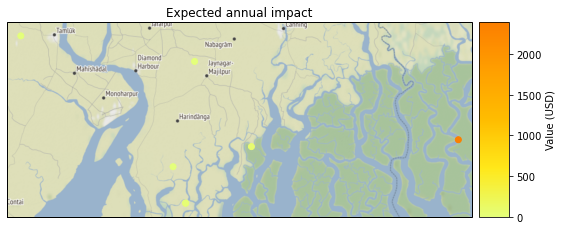

In [3]:
imp_pnt.plot_basemap_eai_exposure(buffer=5000)

## Making videos

Given a fixed exposure and impact functions, a sequnce of hazards can be visualized hitting the exposures.

2021-02-08 17:33:49,616 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-02-08 17:33:49,617 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-02-08 17:33:49,618 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-02-08 17:33:49,619 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-02-08 17:33:49,620 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2021-02-08 17:33:51,231 - climada.util.finance - INFO - GDP USA 2016: 1.871e+13.
2021-02-08 17:33:51,295 - climada.util.finance - INFO - Income group USA 2016: 4.
2021-02-08 17:33:51,296 - climada.entity.exposures.black_marble - INFO - Nightlights from NASA's earth observatory for year 2016.
2021-02-08 17:34:28,974 - climada.entity.exposures.black_marble - INFO - Processing country United States Of America.
2021-02-08 17:39:22,943 - climada.entity.exposures.

/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/geopandas/geodataframe.py:91: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


2021-02-08 17:39:24,578 - climada.hazard.tc_tracks - INFO - Progress: 100%
2021-02-08 17:39:24,600 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.


/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2021-02-08 17:39:30,443 - climada.util.coordinates - INFO - dist_to_coast: UTM 32616 (1/2)


/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2021-02-08 17:39:42,347 - climada.util.coordinates - INFO - dist_to_coast: UTM 32617 (2/2)


/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2021-02-08 17:40:00,329 - climada.hazard.trop_cyclone - INFO - Mapping 1 tracks to 27422 coastal centroids.
2021-02-08 17:40:00,348 - climada.hazard.trop_cyclone - INFO - Progress: 100%
2021-02-08 17:40:00,358 - climada.hazard.trop_cyclone - INFO - Mapping 1 tracks to 29511 coastal centroids.
2021-02-08 17:40:00,380 - climada.hazard.trop_cyclone - INFO - Progress: 100%
2021-02-08 17:40:00,392 - climada.hazard.trop_cyclone - INFO - Mapping 1 tracks to 31302 coastal centroids.
2021-02-08 17:40:00,417 - climada.hazard.trop_cyclone - INFO - Progress: 100%
2021-02-08 17:40:00,427 - climada.hazard.trop_cyclone - INFO - Mapping 1 tracks to 32586 coastal centroids.
2021-02-08 17:40:00,455 - climada.hazard.trop_cyclone - INFO - Progress: 100%
2021-02-08 17:40:00,465 - climada.hazard.trop_cyclone - INFO - Mapping 1 tracks to 34511 coastal centroids.
2021-02-08 17:40:00,489 - climada.hazard.trop_cyclone - INFO - Progress: 100%
2021-02-08 17:40:00,498 - climada.hazard.trop_cyclone - INFO - Mapping

2021-02-08 17:40:03,594 - climada.engine.impact - INFO - Missing exposures impact functions for hazard if_TC. Using impact functions in if_.
2021-02-08 17:40:03,599 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-08 17:40:03,600 - climada.engine.impact - INFO - Calculating damage for 24024 assets (>0) and 1 events.
2021-02-08 17:40:03,601 - climada.engine.impact - INFO - Missing exposures impact functions for hazard if_TC. Using impact functions in if_.
2021-02-08 17:40:03,605 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-08 17:40:03,607 - climada.engine.impact - INFO - Calculating damage for 24024 assets (>0) and 1 events.
2021-02-08 17:40:03,607 - climada.engine.impact - INFO - Missing exposures impact functions for hazard if_TC. Using impact functions in if_.
2021-02-08 17:40:03,612 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2021-02-08 17:40:03,614 - climada.engine.

/Users/ckropf/Documents/Climada/climada_python/climada/util/plot.py:314: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()
  9%|▉         | 2/22 [00:12<02:04,  6.23s/it]/Users/ckropf/opt/anaconda3/envs/climada_uncertainty/lib/python3.7/site-packages/cartopy/mpl/feature_artist.py:225: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **dict(style))
23it [07:31, 19.65s/it]                        


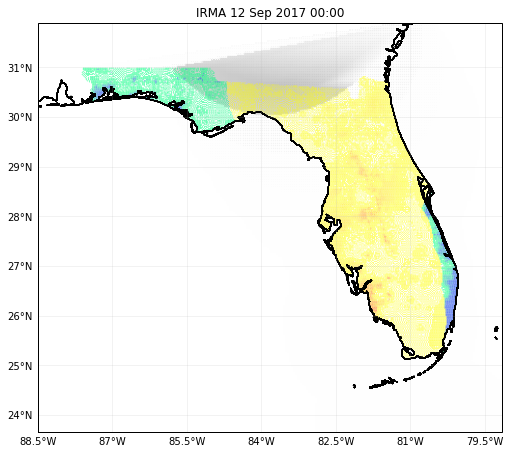

In [4]:
# exposure
from climada.entity import BlackMarble, add_sea
country_name = {'United States Of America': ['Florida']}
exp_video = BlackMarble()
exp_video.set_countries(country_name, 2016, res_km=2.5)
exp_video.check()

# impact function
if_def = IFTropCyclone()
if_def.set_emanuel_usa()
ifs_video = ImpactFuncSet()
ifs_video.append(if_def)
ifs_video.check()

# compute sequence of hazards using TropCyclone video_intensity method
exp_sea = add_sea(exp_video, (100, 5))
centr_video = Centroids()
centr_video.set_lat_lon(exp_sea.gdf.latitude.values, exp_sea.gdf.longitude.values)
centr_video.check()

track_name = '2017242N16333' 
tr_irma = TCTracks()
tr_irma.read_ibtracs_netcdf(provider='usa', storm_id=track_name) # IRMA 2017

tc_video = TropCyclone()
tc_list, _ = tc_video.video_intensity(track_name, tr_irma, centr_video) # empty file name to not to write the video

# generate video of impacts
file_name='./results/irma_imp_fl.gif'
imp_video = Impact()
imp_list = imp_video.video_direct_impact(exp_video, ifs_video, tc_list, file_name)
